**Setting the Environment**

In [ ]:
# Step 1: Force correct versions
!pip uninstall -y tensorflow-io
!pip install -q tensorflow==2.15.0 tensorflow-io==0.35.0 tensorflow-hub==0.15.0

# Step 2: Restart runtime after install
import os
os.kill(os.getpid(), 9)


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

print(tf.__version__)
print(tfio.__version__)
print(hub.__version__)

2.15.0
0.35.0
0.15.0


**Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing Modules**

In [ ]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

**Loading Audio and Extracting Embeddings**

In [ ]:
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

def load_audio_and_embed(filepath):
  audio_tensor = tfio.audio.AudioIOTensor(filepath)
  audio = tf.squeeze(audio_tensor.to_tensor(), axis=[-1])
  sample_rate = audio_tensor.rate

  if sample_rate != 16000:
    audio = tfio.audio.resample(audio, rate_in=sample_rate, rate_out=16000)

  # Cast audio to float32 as required by YAMNet
  audio = tf.cast(audio, tf.float32)

  # Extract embeddings (scores, embeddings, spectrogram)
  _, embeddings, _ = yamnet_model(audio)
  return tf.reduce_mean(embeddings, axis=0)    # average over time

**Preparing Dataset - Reading and Labeling files**

In [ ]:
import wave
file = '/content/drive/MyDrive/fine_tune_data/siren/123688-8-1-5.wav'

with wave.open(file, 'rb') as wav_file:
  print("Channels:", wav_file.getnchannels())
  print("Sample Width:", wav_file.getsampwidth())
  print("Frame Rate(Sample rate): ", wav_file.getframerate())
  print("Frames: ", wav_file.getnframes())

Channels: 1
Sample Width: 2
Frame Rate(Sample rate):  16000
Frames:  64000


As from the above result we can see that our files are not competible with YAMNet
<br>
Expected for YAMNet:
<ol>
<li> Mono = 1 channel
<li> Sample rate = 16000
<li> Non-zero frames
</ol>

In [ ]:
# FIX : Converting Audio to YAMNet- Compatible Format
!pip install pydub
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
from pydub import AudioSegment
import os

input_root = "/content/drive/MyDrive/fine_tune_data"
# tracking how many failed files
fail_count = 0
success_count = 0
# Walk through all label folders
for label in os.listdir(input_root):
  label_path = os.path.join(input_root, label)
  if not os.path.isdir(label_path):
    continue
  print(f"🎧 Processing label: {label}")

  for filename in os.listdir(label_path):
    file_path = os.path.join(label_path, filename)
    if not (filename.endswith(".wav") or filename.endswith(".ogg")):
      continue    # skip non-audio files
    try:
      audio = AudioSegment.from_file(file_path)
      audio = audio.set_channels(1)        # Mono
      audio = audio.set_frame_rate(16000)  # 16 kHz
      # Overwrite with processed version
      audio.export(file_path, format = 'wav')
      success_count += 1
    except Exception as e:
      print(f"❌ Failed: {filename} - Reason: {e}")
      fail_count += 1
print(f"\n ✅ Done! Converted: {success_count} files | Skipped(corrupt or unsupported): {fail_count} files.")

🎧 Processing label: gun_shot
🎧 Processing label: scream_augmented
🎧 Processing label: glass_break
🎧 Processing label: normal
❌ Failed: 19007-4-0-0.wav - Reason: Decoding failed. ffmpeg returned error code: 1

Output from ffmpeg/avlib:

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-lib

In [ ]:
import os

source_dir = '/content/drive/MyDrive/fine_tune_data'
target_dir = '/content/drive/MyDrive/clean_wavs'

os.makedirs(target_dir, exist_ok=True)

for file in os.listdir(source_dir):
    if file.endswith('.wav'):
        in_path = os.path.join(source_dir, file)
        out_path = os.path.join(target_dir, file)
        !ffmpeg -y -i "{in_path}" -acodec pcm_s16le -ar 16000 "{out_path}"


In [ ]:
import os

source_dir = '/content/drive/MyDrive/fine_tune_data'
target_dir = '/content/drive/MyDrive/clean_wavs'

os.makedirs(target_dir, exist_ok=True)

for label in os.listdir(source_dir):
    label_path = os.path.join(source_dir, label)
    if not os.path.isdir(label_path):
        continue

    target_label_dir = os.path.join(target_dir, label)
    os.makedirs(target_label_dir, exist_ok=True)

    print(f"Converting audio files for label: {label}")
    for file in os.listdir(label_path):
        in_path = os.path.join(label_path, file)
        if not (file.endswith(".wav") or file.endswith(".ogg")):
            continue

        out_path = os.path.join(target_label_dir, os.path.splitext(file)[0] + '.wav')

        try:
            # Use ffmpeg to convert to standard WAV format
            # -y: overwrite output files without asking
            # -i: input file
            # -acodec pcm_s16le: specify output audio codec (PCM signed 16-bit little-endian)
            # -ar 16000: specify audio sample rate (16000 Hz)
            # -ac 1: set number of audio channels to 1 (mono)
            !ffmpeg -y -i "{in_path}" -acodec pcm_s16le -ar 16000 -ac 1 "{out_path}" > /dev/null 2>&1
        except Exception as e:
            print(f"Failed to convert {file}: {e}")

print("Conversion complete.")

Converting audio files for label: gun_shot
Converting audio files for label: scream_augmented
Converting audio files for label: glass_break
Converting audio files for label: normal
Converting audio files for label: help_augmented
Converting audio files for label: siren
Conversion complete.


Now that the audio files have been converted to a consistent format in the `/content/drive/MyDrive/clean_wavs` directory, we can update the code to load the embeddings from this new directory.

In [ ]:
X = []
y = []

emergency_labels = ['siren', 'scream_augmented', 'help_augmented', 'gun_shot', 'glass_break']
# Change base_dir to point to the directory with cleaned WAV files
base_dir = '/content/drive/MyDrive/clean_wavs'

for label in os.listdir(base_dir):
  label_path = os.path.join(base_dir, label)
  if not os.path.isdir(label_path):
    continue
  class_val = 1 if label in emergency_labels else 0
  print(f"Processing label: {label}")
  for file in os.listdir(label_path):
    # Ensure we only process .wav files in the cleaned directory
    if not file.endswith('.wav'):
      continue
    file_path = os.path.join(label_path, file)
    try:
        embedding = load_audio_and_embed(file_path)
        if embedding is not None:
          X.append(embedding.numpy())
          y.append(class_val)
    except Exception as e:
        print(f"Failed to process {file}: {e}")


# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"\nFinished processing. Total samples: {len(X)}")

Processing label: gun_shot
Processing label: scream_augmented
Processing label: glass_break
Processing label: normal
Processing label: help_augmented
Processing label: siren

Finished processing. Total samples: 9073


**Training the Classifier**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)
# defining the model
model = models.Sequential([
    layers.Input(shape=(1024,)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation= 'relu'),
    layers.Dense(1, activation= 'sigmoid')      # Binary Output
])

# Compiling the model
model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics = ['accuracy'])
# Callbacks
early_stop = EarlyStopping(monitor= 'val_loss', patience= 7, verbose= 1, mode= 'min', restore_best_weights= True)
checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive/best_emergency_model.h5', monitor= 'val_loss', save_best_only= True)
# Training the model
history = model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs= 50, batch_size= 32, callbacks= [early_stop, checkpoint])

Epoch 1/50
227/227 [==============================] - 3s 8ms/step - loss: 0.8522 - accuracy: 0.8129 - val_loss: 0.4495 - val_accuracy: 0.8579
Epoch 2/50
  1/227 [..............................] - ETA: 1s - loss: 0.6962 - accuracy: 0.9375

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 2s 8ms/step - loss: 0.5864 - accuracy: 0.8374 - val_loss: 0.4071 - val_accuracy: 0.8705
Epoch 3/50
 13/227 [>.............................] - ETA: 1s - loss: 0.3426 - accuracy: 0.8822

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 2s 9ms/step - loss: 0.4585 - accuracy: 0.8537 - val_loss: 0.4074 - val_accuracy: 0.8848
Epoch 4/50
227/227 [==============================] - 2s 8ms/step - loss: 0.4337 - accuracy: 0.8628 - val_loss: 0.3442 - val_accuracy: 0.8887
Epoch 5/50
 19/227 [=>............................] - ETA: 1s - loss: 0.4206 - accuracy: 0.8865

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 1s 6ms/step - loss: 0.3993 - accuracy: 0.8705 - val_loss: 0.3299 - val_accuracy: 0.8865
Epoch 6/50
 22/227 [=>............................] - ETA: 0s - loss: 0.3309 - accuracy: 0.8807

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 1s 6ms/step - loss: 0.3517 - accuracy: 0.8737 - val_loss: 0.3171 - val_accuracy: 0.8705
Epoch 7/50
 22/227 [=>............................] - ETA: 0s - loss: 0.3878 - accuracy: 0.8636

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 1s 6ms/step - loss: 0.3532 - accuracy: 0.8771 - val_loss: 0.3030 - val_accuracy: 0.8937
Epoch 8/50
 22/227 [=>............................] - ETA: 1s - loss: 0.3133 - accuracy: 0.8949

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 1s 6ms/step - loss: 0.3371 - accuracy: 0.8794 - val_loss: 0.3039 - val_accuracy: 0.8876
Epoch 9/50
227/227 [==============================] - 1s 6ms/step - loss: 0.3400 - accuracy: 0.8796 - val_loss: 0.2940 - val_accuracy: 0.8959
Epoch 10/50
 22/227 [=>............................] - ETA: 1s - loss: 0.2915 - accuracy: 0.8949

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 1s 6ms/step - loss: 0.3150 - accuracy: 0.8854 - val_loss: 0.2925 - val_accuracy: 0.9030
Epoch 11/50
 20/227 [=>............................] - ETA: 1s - loss: 0.3218 - accuracy: 0.8922

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 2s 7ms/step - loss: 0.3342 - accuracy: 0.8826 - val_loss: 0.2869 - val_accuracy: 0.8942
Epoch 12/50
 15/227 [>.............................] - ETA: 1s - loss: 0.3503 - accuracy: 0.8729

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 2s 10ms/step - loss: 0.3059 - accuracy: 0.8910 - val_loss: 0.2904 - val_accuracy: 0.8964
Epoch 13/50
227/227 [==============================] - 2s 8ms/step - loss: 0.3043 - accuracy: 0.8887 - val_loss: 0.3222 - val_accuracy: 0.8959
Epoch 14/50
227/227 [==============================] - 1s 6ms/step - loss: 0.3166 - accuracy: 0.8861 - val_loss: 0.2903 - val_accuracy: 0.8953
Epoch 15/50
227/227 [==============================] - 1s 6ms/step - loss: 0.3008 - accuracy: 0.8918 - val_loss: 0.3020 - val_accuracy: 0.8926
Epoch 16/50
227/227 [==============================] - 1s 6ms/step - loss: 0.2979 - accuracy: 0.8910 - val_loss: 0.2956 - val_accuracy: 0.8964
Epoch 17/50
227/227 [==============================] - 1s 6ms/step - loss: 0.3225 - accuracy: 0.8902 - val_loss: 0.2740 - val_accuracy: 0.9030
Epoch 18/50
 21/227 [=>............................] - ETA: 1s - loss: 0.2441 - accuracy: 0.9107

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 1s 6ms/step - loss: 0.2990 - accuracy: 0.8898 - val_loss: 0.2705 - val_accuracy: 0.9003
Epoch 19/50
 21/227 [=>............................] - ETA: 1s - loss: 0.2854 - accuracy: 0.8958

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 1s 6ms/step - loss: 0.2917 - accuracy: 0.8960 - val_loss: 0.2690 - val_accuracy: 0.8997
Epoch 20/50
 22/227 [=>............................] - ETA: 1s - loss: 0.3216 - accuracy: 0.8864

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 1s 6ms/step - loss: 0.2994 - accuracy: 0.8943 - val_loss: 0.2844 - val_accuracy: 0.9036
Epoch 21/50
227/227 [==============================] - 2s 10ms/step - loss: 0.2980 - accuracy: 0.8940 - val_loss: 0.2866 - val_accuracy: 0.8959
Epoch 22/50
227/227 [==============================] - 2s 8ms/step - loss: 0.3011 - accuracy: 0.8938 - val_loss: 0.3035 - val_accuracy: 0.9019
Epoch 23/50
227/227 [==============================] - 1s 6ms/step - loss: 0.2994 - accuracy: 0.8947 - val_loss: 0.2727 - val_accuracy: 0.9019
Epoch 24/50
227/227 [==============================] - 1s 6ms/step - loss: 0.2899 - accuracy: 0.8971 - val_loss: 0.2728 - val_accuracy: 0.9030
Epoch 25/50
225/227 [============================>.] - ETA: 0s - loss: 0.2937 - accuracy: 0.8960

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 2s 9ms/step - loss: 0.2933 - accuracy: 0.8961 - val_loss: 0.2666 - val_accuracy: 0.9052
Epoch 26/50
227/227 [==============================] - 1s 6ms/step - loss: 0.2868 - accuracy: 0.8983 - val_loss: 0.2898 - val_accuracy: 0.9036
Epoch 27/50
227/227 [==============================] - 1s 6ms/step - loss: 0.2855 - accuracy: 0.8979 - val_loss: 0.2671 - val_accuracy: 0.9080
Epoch 28/50
227/227 [==============================] - 1s 6ms/step - loss: 0.2905 - accuracy: 0.8998 - val_loss: 0.2806 - val_accuracy: 0.9025
Epoch 29/50
227/227 [==============================] - 2s 8ms/step - loss: 0.2801 - accuracy: 0.9000 - val_loss: 0.2814 - val_accuracy: 0.9030
Epoch 30/50
227/227 [==============================] - 2s 11ms/step - loss: 0.2771 - accuracy: 0.8982 - val_loss: 0.2628 - val_accuracy: 0.9080
Epoch 31/50
 13/227 [>.............................] - ETA: 1s - loss: 0.2380 - accuracy: 0.9207

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 2s 7ms/step - loss: 0.2861 - accuracy: 0.8979 - val_loss: 0.2569 - val_accuracy: 0.9096
Epoch 32/50
 20/227 [=>............................] - ETA: 1s - loss: 0.3025 - accuracy: 0.8969

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 2s 8ms/step - loss: 0.2831 - accuracy: 0.8996 - val_loss: 0.2899 - val_accuracy: 0.9019
Epoch 33/50
227/227 [==============================] - 2s 7ms/step - loss: 0.2724 - accuracy: 0.8993 - val_loss: 0.2578 - val_accuracy: 0.9069
Epoch 34/50
227/227 [==============================] - 1s 6ms/step - loss: 0.2696 - accuracy: 0.9060 - val_loss: 0.2565 - val_accuracy: 0.9030
Epoch 35/50
 21/227 [=>............................] - ETA: 1s - loss: 0.2418 - accuracy: 0.9137

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 1s 6ms/step - loss: 0.2701 - accuracy: 0.9014 - val_loss: 0.2506 - val_accuracy: 0.9080
Epoch 36/50
 22/227 [=>............................] - ETA: 1s - loss: 0.2595 - accuracy: 0.9048

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 1s 6ms/step - loss: 0.2617 - accuracy: 0.9047 - val_loss: 0.2564 - val_accuracy: 0.9069
Epoch 37/50
227/227 [==============================] - 2s 8ms/step - loss: 0.2771 - accuracy: 0.9052 - val_loss: 0.2655 - val_accuracy: 0.9069
Epoch 38/50
227/227 [==============================] - 4s 17ms/step - loss: 0.2596 - accuracy: 0.9085 - val_loss: 0.2529 - val_accuracy: 0.9096
Epoch 39/50
227/227 [==============================] - 1s 6ms/step - loss: 0.2574 - accuracy: 0.9051 - val_loss: 0.2527 - val_accuracy: 0.9146
Epoch 40/50
227/227 [==============================] - 1s 6ms/step - loss: 0.2710 - accuracy: 0.9048 - val_loss: 0.2888 - val_accuracy: 0.8893
Epoch 41/50
227/227 [==============================] - 1s 6ms/step - loss: 0.2782 - accuracy: 0.9037 - val_loss: 0.2704 - val_accuracy: 0.9118
Epoch 42/50
227/227 [==============================] - 1s 6ms/step - loss: 0.2777 - accuracy: 0.9016 - val_loss: 0.2830 - val_accuracy: 0.9014
Epoch 42: 

**Ploting Training History**

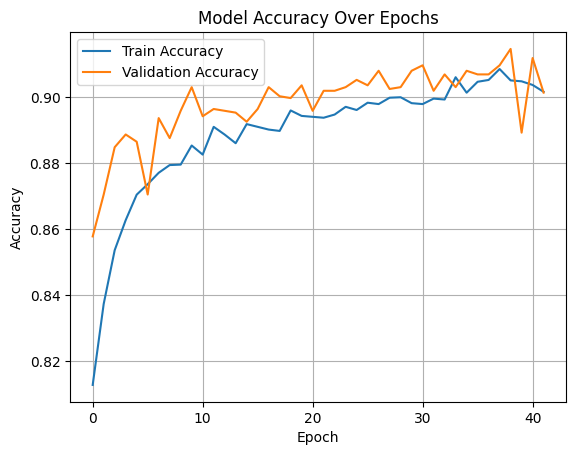

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],
         label= 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label= 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Model Accuracy Over Epochs')
plt.show()

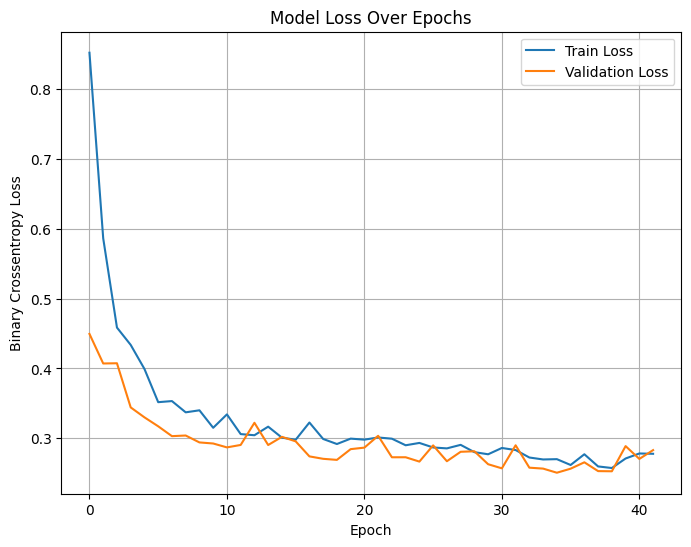

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label= 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.title('Model Loss Over Epochs')
plt.show()

**Saving the final model for deployment**

In [ ]:
# Saving as .h5
model.save('/content/drive/MyDrive/emergency_audio_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Converting to .tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('/content/drive/MyDrive/emergency_audio_model.tflite', 'wb') as f:
  f.write(tflite_model)